In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
from fastai.vision import *
from pathlib import Path
from skimage.io import imread,imshow,imsave
import warnings
from collections import defaultdict
import pandas as pd

In [3]:
from tqdm import tqdm_notebook  as tqdm
import os
import gc
import torch
from fastai.vision.interpret import SegmentationInterpretation

In [4]:
def clean_instance():
    gc.collect()
    torch.cuda.empty_cache()

In [5]:
os.sched_getaffinity(0)
os.cpu_count()

16

In [6]:
path_img = Path('train_images')

In [7]:
df = pd.read_csv('train.csv')

In [8]:
lbl_dir = Path('train_labels')
tst_dir = Path('test_images')
mixup_dir = Path('mixup_data_trn')
mixup_lbl = Path('mixup_labels')

In [9]:
# remove tranforms to predict on train_ds
data = (SegmentationItemList.from_folder(mixup_dir) # change dir
        #.filter_by_rand(0.01)
       .split_by_rand_pct(0.2)
       .label_from_func(lambda l:mixup_lbl/(l.name),classes=['nodef','t1def','t2def','t3def','t4def'])#dir,name->stem+.png
        #.add_test(get_image_files(tst_dir))
       #.transform(get_transforms(max_rotate=0,max_warp=0), tfm_y=True, size=(256,1600))
       .databunch(bs=4,num_workers=15)
       .normalize(stats=imagenet_stats))

# exploring data pipeline

In [10]:
d = SegmentationItemList.from_folder(path_img)

In [11]:
d

SegmentationItemList (12568 items)
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
Path: train_images

In [9]:
d1 = d.split_by_rand_pct()

In [10]:
d1

ItemLists;

Train: SegmentationItemList (10055 items)
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
Path: train_images;

Valid: SegmentationItemList (2513 items)
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
Path: train_images;

Test: None

In [11]:
d2 = d1.label_from_func(lambda l:lbl_dir/(l.stem+".png"),classes=['nodef','t1def','t2def','t3def','t4def'])

In [12]:
d2

LabelLists;

Train: LabelList (10055 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: SegmentationLabelList
ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600)
Path: train_images;

Valid: LabelList (2513 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: SegmentationLabelList
ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600)
Path: train_images;

Test: None

In [13]:
d2.get_processors()

([], [<fastai.vision.data.SegmentationProcessor at 0x7f1d4c7d96d8>])

# prepare learner

In [10]:
def dice(input, targs, iou=False, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    #pdb.set_trace()
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    local = []
    for cat in [1,2,3,4]:
        input_ = (input == cat)
        targs_ = (targs == cat)
        intersect = (input_ * targs_).sum(dim=1).float()
        union = (input_+targs_).sum(dim=1).float()
        if not iou: l = 2. * intersect / union
        else: l = intersect / (union-intersect+eps)
        l[union == 0.] = 1.
        local.append(l)
    for num,met in enumerate(local):
        if num == 0:
            met_img = met
        else:
            met_img += met
    met_img = met_img/4.0
    return met_img.mean()

In [11]:
from fastai.callbacks import *
from torchvision.models import *
from mxresnet import *
from functools import partial
from ranger import *

Mish activation loaded...


In [12]:
def fit_with_annealing(learn:Learner, num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.7)->None:
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.fit(num_epoch)

In [13]:
opt_func = partial(Ranger,  betas=(0.9,0.99), eps=1e-6)

In [14]:
learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()

Using Ranger Optimizer...


In [15]:
learn.load('wednesday10');

In [18]:
interp = SegmentationInterpretation.from_learner(learn)

In [23]:
interp.top_losses(sizes=(2,2))

torch.return_types.topk(
values=tensor([18.8013, 18.7944, 18.7944,  ...,  0.0000,  0.0000,  0.0000]),
indices=tensor([70725476, 70725604, 70725475,  ..., 57027091, 57027092, 12594802]))

In [48]:
learn.unfreeze()

Using Ranger Optimizer...


In [16]:
learn.lr_find()

Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


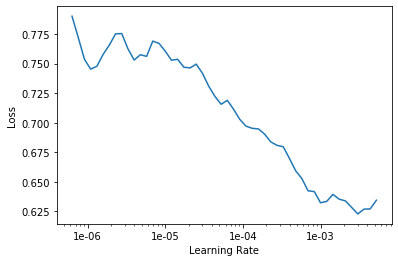

In [17]:
learn.recorder.plot()

In [18]:
fit_with_annealing(learn, 2, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time


KeyboardInterrupt: 

In [20]:
fit_with_annealing(learn, 2, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.141842,0.130965,0.651606,34:48
1,0.108608,0.101966,0.713728,34:51


In [22]:
learn.save("wednesday")

In [23]:
learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()
learn.load('wednesday');

Using Ranger Optimizer...
set state called


Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


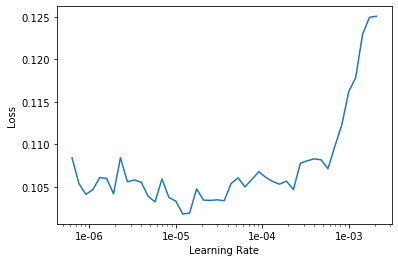

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
fit_with_annealing(learn, 1, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.092908,0.088667,0.748591,35:50


In [26]:
learn.save("wednesday1")

In [27]:
learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()
learn.load('wednesday1');

Using Ranger Optimizer...
set state called


Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


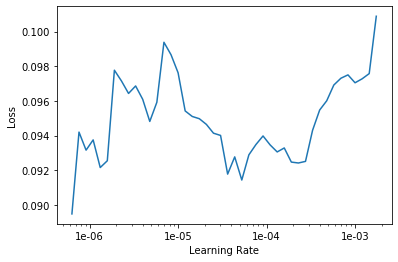

In [28]:
#learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [29]:
fit_with_annealing(learn, 2, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.097567,0.087282,0.773462,37:00
1,0.076262,0.070516,0.801758,36:45


In [30]:
learn.save('wednesday2')

Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


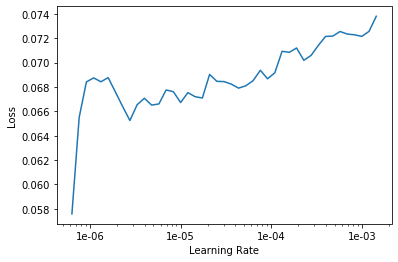

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
fit_with_annealing(learn, 1, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.073559,0.066381,0.816346,36:42


In [33]:
learn.save('wednesday3')

Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


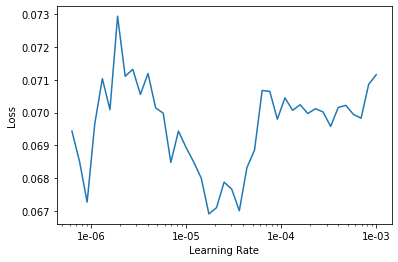

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()
learn.load('wednesday3');

Using Ranger Optimizer...
set state called


In [36]:
fit_with_annealing(learn, 2, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.071111,0.066227,0.821213,35:42
1,0.058797,0.057846,0.844755,34:52


In [37]:
learn.save('wednesday4')

In [38]:
learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()
learn.load('wednesday4');

Using Ranger Optimizer...
set state called


Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


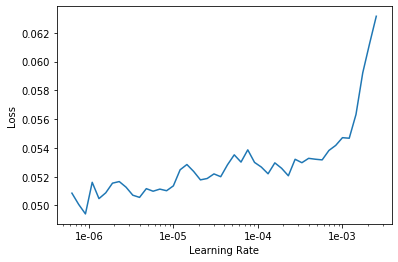

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
fit_with_annealing(learn, 1, 0.0006)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.076686,0.073563,0.798872,34:43


In [41]:
learn.save('wednesday5')

In [42]:
learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()
learn.load('wednesday4');

Using Ranger Optimizer...
set state called


Using Ranger Optimizer...
Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


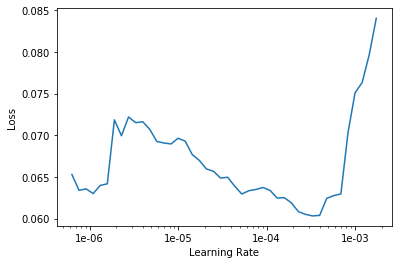

In [43]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [44]:
fit_with_annealing(learn, 2, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.069930,0.068540,0.801888,36:19
1,0.056397,0.053439,0.855681,35:57


In [45]:
learn.save('wednesday6')

In [46]:
learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()
learn.load('wednesday6');

Using Ranger Optimizer...


Using Ranger Optimizer...
Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


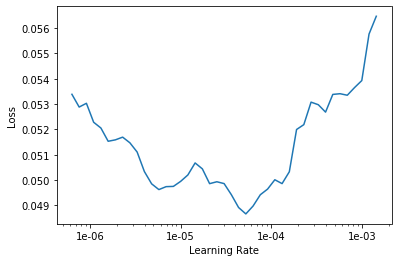

In [47]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [48]:
fit_with_annealing(learn, 2, 0.00006)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.053156,0.052325,0.854940,38:35
1,0.047204,0.045492,0.876972,39:16


In [49]:
learn.save('wednesday7')

In [50]:
learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()
learn.load('wednesday7');

Using Ranger Optimizer...


Using Ranger Optimizer...
Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


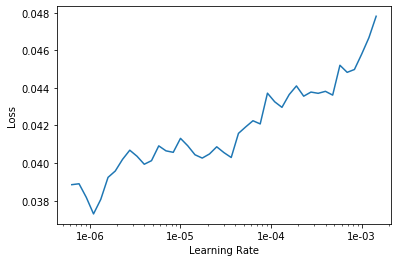

In [51]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [52]:
fit_with_annealing(learn, 1, 0.00006)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.042651,0.043954,0.880256,40:13


In [53]:
learn.save('wednesday8')

In [54]:
learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()
learn.load('wednesday8');

Using Ranger Optimizer...


Using Ranger Optimizer...
Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


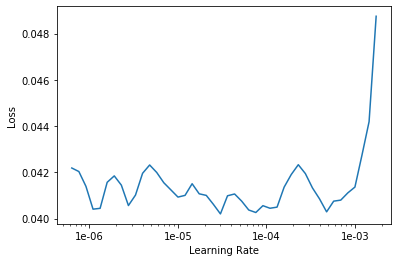

In [55]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [56]:
fit_with_annealing(learn, 1, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.043312,0.044536,0.881233,35:54


In [57]:
learn.save('wednesday9')

In [58]:
# 9 looks good
learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()
learn.load('wednesday9');

Using Ranger Optimizer...


Using Ranger Optimizer...
Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


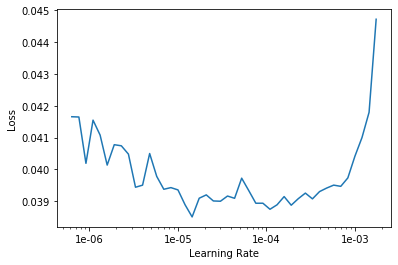

In [59]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [80]:
fit_with_annealing(learn, 2, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.047784,0.054496,0.851899,35:55
1,0.037286,0.040616,0.891964,37:50


In [81]:
learn.save('wednesday10')

Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


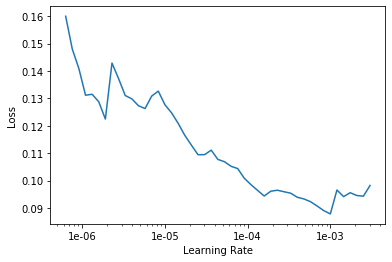

In [16]:
# original data set, fine tuning
learn.lr_find()
learn.recorder.plot()

In [17]:
# original data set, fine tuning
fit_with_annealing(learn, 2, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.048688,0.037437,0.902511,21:56
1,0.029354,0.024046,0.924910,21:52


In [21]:
learn.save('wednesday11')

Using Ranger Optimizer...
Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


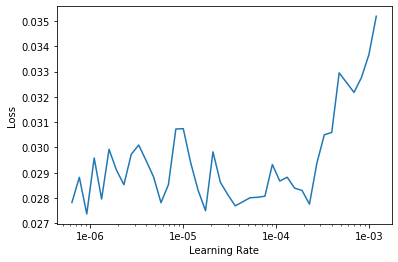

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

learn.save('a',return_path=True)

In [42]:
fit_with_annealing(learn, 1, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.116953,0.113497,0.635256,02:26


In [19]:
learn.freeze()

Using Ranger Optimizer...


In [21]:
fit_with_annealing(learn,2,0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time


In [91]:
fit_with_annealing(learn,1,0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time


In [124]:
pth = learn.save('ranger_trn',return_path=True);
pth

PosixPath('train_images/models/ranger_trn.pth')

In [36]:
len(learn.recorder.losses)

881

In [37]:
881/158

5.575949367088608

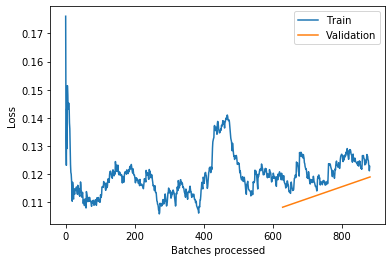

In [34]:
learn.recorder.plot_losses()

## testing

In [75]:
xt,yt = learn.data.valid_ds[3]

In [76]:
yp = learn.predict(xt)

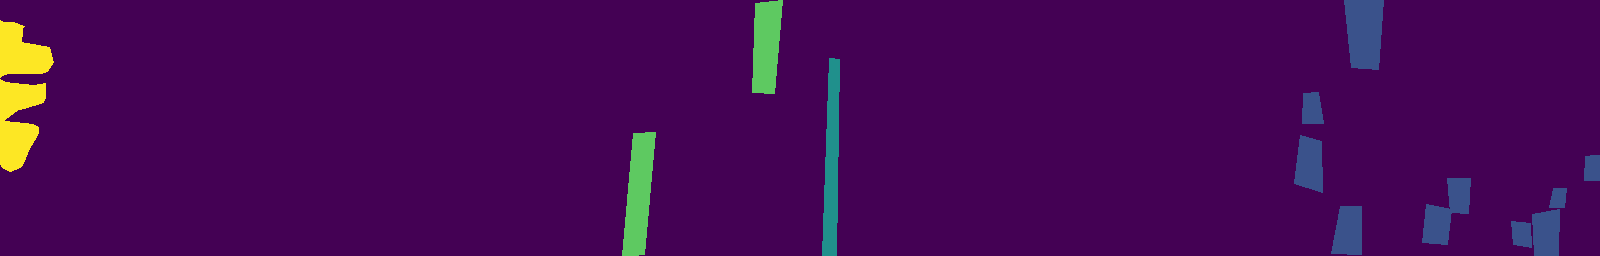

In [77]:
yt

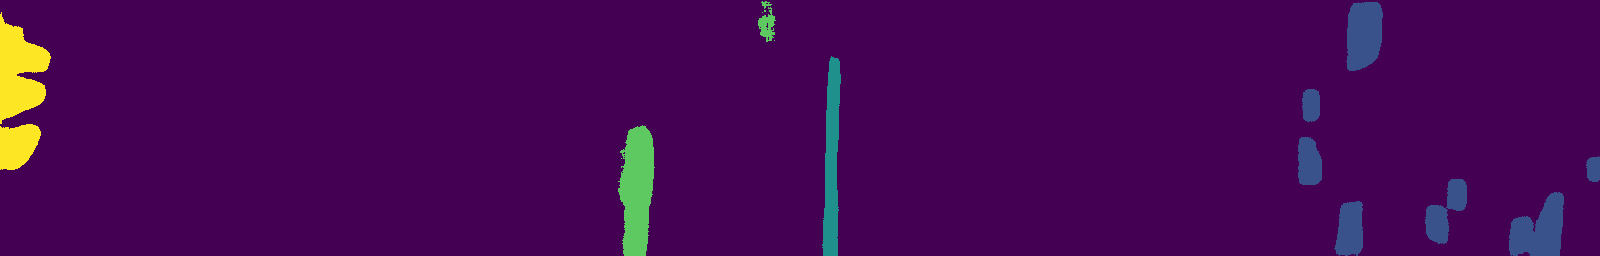

In [78]:
yp[0]

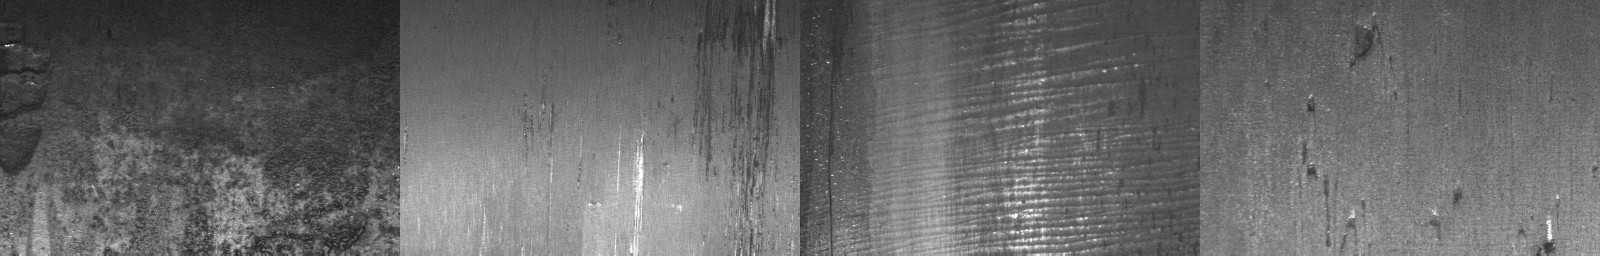

In [79]:
xt

In [200]:
print("actual: ",torch.unique(yt.data), "--- prediction: ",torch.unique(yp[0].data))

actual:  tensor([0, 3]) --- prediction:  tensor([0, 1, 3])


In [201]:
(yp[0].data == 1).sum(),(yt.data == 1).sum()

(tensor(6), tensor(0))

# predict

In [10]:
data1 = (SegmentationItemList.from_folder(path_img)
        #.filter_by_rand(0.01)
       .split_by_rand_pct(0.06)
       .label_from_func(lambda l:lbl_dir/(l.stem+".png"),classes=['nodef','t1def','t2def','t3def','t4def'])
        .add_test(get_image_files(tst_dir))
       .transform(get_transforms(max_rotate=0,max_warp=0), size=(256,1600))
       .databunch(bs=4)
       .normalize(stats=imagenet_stats))

In [10]:
#data.device = torch.device('cpu')

In [15]:
learn = unet_learner(data1, resnet18,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()

Using Ranger Optimizer...


In [13]:
len(learn.data.valid_ds),len(learn.data.test_ds)

(754, 1801)

In [14]:
learn.load('a');

set state called


In [16]:
#learn.fit(1,0.00001)

In [16]:
preds = learn.get_preds(DatasetType.Valid)

In [18]:
scores = []
for i in range(preds[0].shape[0]):
    scores.append(dice_from_msks(preds[0][i],preds[1][i]))

In [19]:
_ = np.array(scores)

In [20]:
_.mean(axis=0)

array([0.050302, 0.016373, 0.267995, 0.049106])

In [21]:
fls = learn.data.valid_ds.items

In [22]:
fls[:5]

array([PosixPath('train_images/3a9967d61.jpg'), PosixPath('train_images/e006b532b.jpg'),
       PosixPath('train_images/6506c22cb.jpg'), PosixPath('train_images/29f80893c.jpg'),
       PosixPath('train_images/976b8a242.jpg')], dtype=object)

In [23]:
df = pd.read_csv('train.csv')

In [24]:
df.head(4)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN


In [24]:
df[df.ImageId_ClassId=='0002cc93b.jpg_1']['EncodedPixels'].values[0]

'29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 92225 39 92481 39 92737 39 92993 39 93248 40 93504 40 93760 40 94026 30 94302 10 189792 7 190034 21 190283 28 190539 28 190795 28 191051 28 191307 28 191563 28 191819 28 192075 28 192331 28 192587 28 192843 23 193099 14 193355 5'

In [25]:
distr = {1:{'id':[],'fls':[]},
         2:{'id':[],'fls':[]},
         3:{'id':[],'fls':[]},
         4:{'id':[],'fls':[]}}
for n,fl in enumerate(fls):
    for i in [1,2,3,4]:
        if not pd.isna(df[df.ImageId_ClassId==fl.name+'_'+str(i)]['EncodedPixels'].values[0]):
            distr[i]['id'].append(n)
            distr[i]['fls'].append(fl)

In [26]:
for i in [1,2,3,4]:
    print(i," : ",len(distr[i]['id']))

1  :  60
2  :  16
3  :  303
4  :  46


In [27]:
_.mean(axis=0)

array([0.050302, 0.016373, 0.267995, 0.049106])

In [16]:
class_ = 3
count = 4
index = distr[class_]['id'][count]
print(learn.data.valid_ds.items[index])

NameError: name 'distr' is not defined

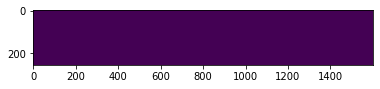

In [37]:
_ = 15
plt.figure(figsize=(10,1))
plt.imshow(torch.argmax(preds[0][_],dim=0).numpy())

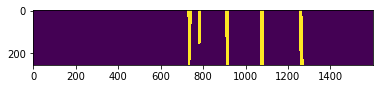

In [57]:
plt.figure(figsize=(10,1))
plt.imshow(preds[1][index].view((256,1600)).numpy())

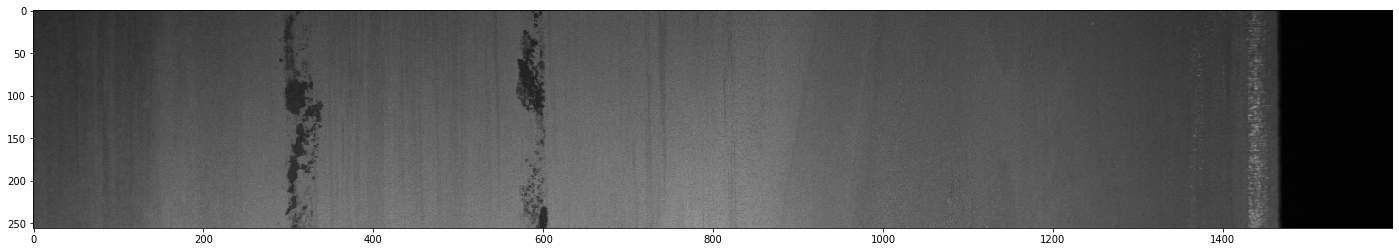

In [38]:
plt.figure(figsize=(40,4))
plt.imshow(imread(learn.data.test_ds.items[_]))

In [59]:
print("truth:",torch.unique(preds[1][index]),",pred:",torch.unique(torch.argmax(preds[0][index],dim=0)))

truth: tensor([0, 3]) ,pred: tensor([0, 1, 3])


In [17]:
preds_dir = Path('valid_preds')
warnings.filterwarnings("ignore")

In [122]:
for num,pred in enumerate(preds[0]):
    #msk = np.zeros((256,1600),dtype=np.uint8)
    msk = np.argmax(pred.numpy(),axis=0).astype(np.uint8)
    #save mask
    imsave(preds_dir/(learn.data.valid_ds.items[num].stem+".png"),msk)

In [40]:
x,y = data.train_ds[5]

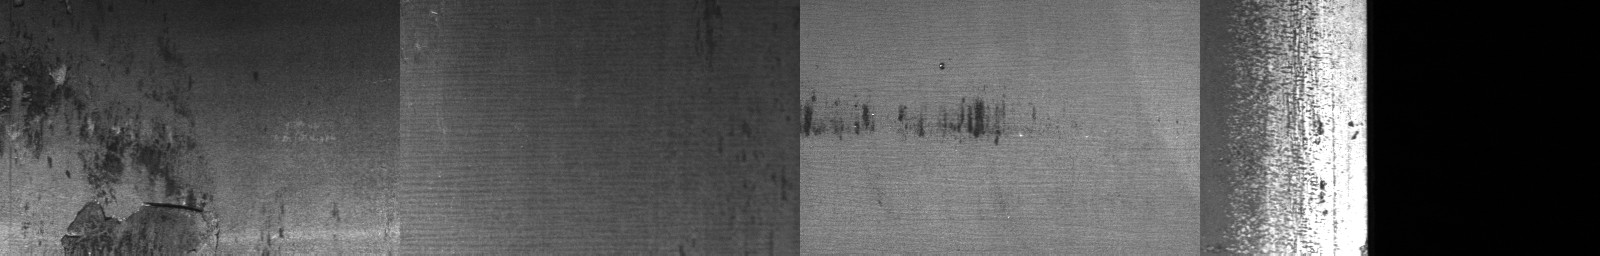

In [41]:
x

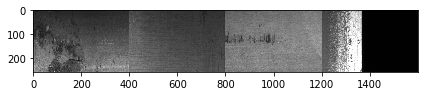

In [42]:
imshow(imread(data.items[5]))

In [48]:
yp = learn.predict(x)

In [49]:
yp[0].shape

torch.Size([1, 256, 1600])

In [18]:
# predict on all train images
num = 0
for x,y in tqdm(data.train_ds):
    msk = learn.predict(x)
    msk = msk[0].data.numpy().astype(np.uint8).squeeze()
    #save mask
    imsave(preds_dir/(learn.data.train_ds.items[num].stem+".png"),msk)
    num += 1

In [19]:
# predict on all valid images
num = 0
for x,y in tqdm(data.valid_ds):
    msk = learn.predict(x)
    msk = msk[0].data.numpy().astype(np.uint8).squeeze()
    #save mask
    imsave(preds_dir/(learn.data.valid_ds.items[num].stem+".png"),msk)
    num += 1

# analyze preds

In [92]:
def_counts = {1:0,2:0,3:0,4:0}
def_fls = {1:[],2:[],3:[],4:[]}
for fl in learn.data.valid_ds.items:
    for i in [1,2,3,4]:
        if not pd.isna(df[df.ImageId_ClassId==fl.name+'_'+str(i)][df.columns[1]].values[0]):
            def_counts[i] += 1
            def_fls[i].append(fl)

In [93]:
def_counts

{1: 184, 2: 67, 3: 1011, 4: 160}

In [100]:
dice_scores = {'name':[],'m':[]}

In [17]:
def dice_from_msks(input, targs, iou=False, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    input = torch.argmax(input,dim=0)
    input = input.view(-1)
    targs = targs.view(-1)
    local = []
    for cat in [1,2,3,4]:
        input_ = (input == cat)
        targs_ = (targs == cat)
        intersect = (input_ * targs_).sum().float()
        union = (input_+targs_).sum().float()
        if not iou: l = 2. * intersect / union
        else: l = intersect / (union-intersect+eps)
        if union == 0:
            l = torch.tensor(0)
        local.append(l.item())

    return local

In [105]:
for fl in tqdm(learn.data.valid_ds.items):
    dice_scores['name'].append(fl.stem)
    fn = fl.stem+'.png'
    pred_nm = preds_dir/fn
    truth_nm = lbl_dir/fn
    p = imread(pred_nm)
    t = imread(truth_nm)
    dice_scores['m'].append(dice_from_msks(p,t))

TypeError: data type not understood

In [116]:
_ = imread(preds_dir/(learn.data.valid_ds.items[0].stem+'.png'))

In [117]:
_.shape

(128, 800)

# analyze the predictions

In [17]:
preds_val = learn.get_preds(DatasetType.Test)

In [19]:
preds_tst_pred = preds_val[0].numpy()
preds_tst_y = preds_val[1].numpy()

In [21]:
with open('preds_tst_pred.pkl','wb') as fl:
    pickle.dump(preds_tst_pred,fl,protocol=4)

In [22]:
with open('preds_val_pred.pkl','rb') as fl:
    preds_val_pred = pickle.load(fl)

In [24]:
with open('preds_tst_pred.pkl','rb') as fl:
    preds_tst_pred = pickle.load(fl)

MemoryError: 

In [25]:
#with open('preds_val_y.pkl','wb') as fl:
#    pickle.dump(preds_val_y,fl)

In [26]:
with open('preds_val_y.pkl','rb') as fl:
    preds_val_y = pickle.load(fl)

In [ ]:
with open('preds_tst_y.pkl','rb') as fl:
    preds_tst_y = pickle.load(fl)